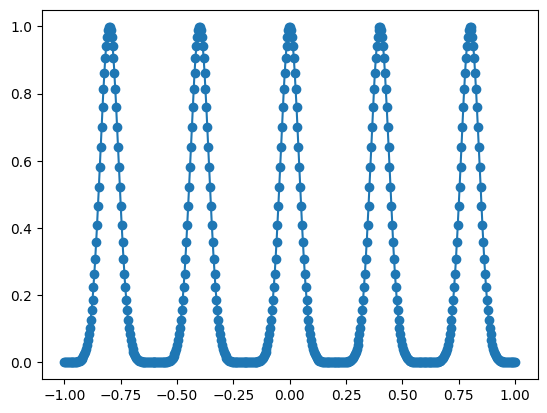

In [2]:
from kan import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib.pyplot as plt


datasets = []

n_peak = 5
n_num_per_peak = 100
n_sample = n_peak * n_num_per_peak

x_grid = torch.linspace(-1,1,steps=n_sample)

x_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2+0.5)

x_sample = torch.stack([torch.linspace(-1/n_peak,1/n_peak,steps=n_num_per_peak)+center for center in x_centers]).reshape(-1,)


y = 0.
for center in x_centers:
    y += torch.exp(-(x_grid-center)**2*300)
    
y_sample = 0.
for center in x_centers:
    y_sample += torch.exp(-(x_sample-center)**2*300)
    

plt.plot(x_grid.detach().numpy(), y.detach().numpy())
plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())

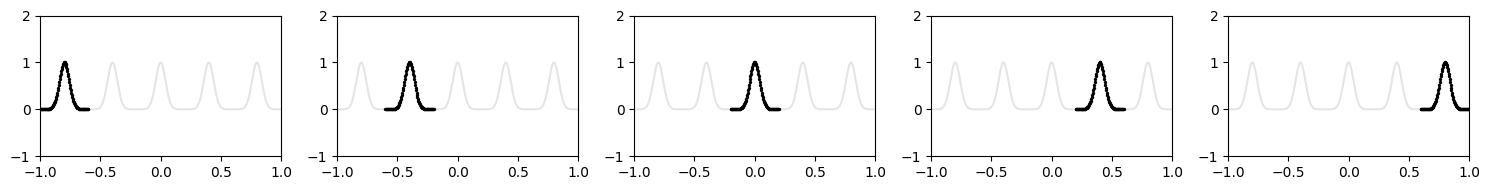

In [3]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.scatter(x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), color="black", s=2)
    plt.xlim(-1,1)
    plt.ylim(-1,2)
plt.tight_layout()
plt.show()

In [4]:
ys = []

# setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# otherwise KAN will have random scaling and shift for samples in previous stages

model = KAN(width=[1,1], grid=200, k=3, noise_scale=0.1, sp_trainable=False, sb_trainable=False, base_fun='zero')

for group_id in range(n_peak):
    dataset = {}
    dataset['train_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['train_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    model.fit(dataset, opt = 'LBFGS', steps=100, update_grid=False);
    y_pred = model(x_grid[:,None])
    ys.append(y_pred.detach().numpy()[:,0])

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.99e-06 | test_loss: 3.99e-06 | reg: 3.31e+00 | : 100%|█| 100/100 [00:01<00:00, 96.61


saving model version 0.1


| train_loss: 4.05e-06 | test_loss: 4.05e-06 | reg: 3.31e+00 | : 100%|█| 100/100 [00:01<00:00, 55.07


saving model version 0.2


| train_loss: 4.00e-06 | test_loss: 4.00e-06 | reg: 3.31e+00 | : 100%|█| 100/100 [00:00<00:00, 157.1


saving model version 0.3


| train_loss: 3.99e-06 | test_loss: 3.99e-06 | reg: 3.31e+00 | : 100%|█| 100/100 [00:00<00:00, 198.7


saving model version 0.4


| train_loss: 3.99e-06 | test_loss: 3.99e-06 | reg: 3.31e+00 | : 100%|█| 100/100 [00:00<00:00, 150.9

saving model version 0.5


Prediction of KAN after each stage

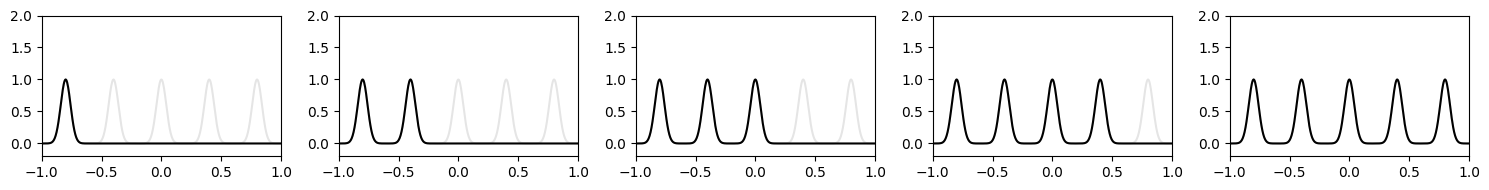

In [5]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.plot(x_grid.detach().numpy(), ys[i-1], color='black')
    plt.xlim(-1,1)
    plt.ylim(-0.2,2)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Fix random seed
torch.manual_seed(0)

# Settings
n_peak = 5
n_num_per_peak = 100
x_grid = torch.linspace(-1, 1, steps=n_peak * n_num_per_peak)
x_centers = 2 / n_peak * (torch.arange(n_peak) - n_peak/2 + 0.5)

In [7]:
x_sample = torch.cat([
    torch.linspace(-1/n_peak, 1/n_peak, steps=n_num_per_peak) + center
    for center in x_centers
])
def gaussian_peaks(x, centers):
    y = torch.zeros_like(x)
    for center in centers:
        y += torch.exp(-(x - center)**2 * 300)
    return y
y_grid = gaussian_peaks(x_grid, x_centers)
y_sample = gaussian_peaks(x_sample, x_centers)

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [9]:
def train(model, x, y, steps=500, lr=0.01):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for _ in range(steps):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
    return model

In [10]:
mlp = MLP()
ys = []

for group_id in range(n_peak):
    x_train = x_sample[group_id * n_num_per_peak:(group_id + 1) * n_num_per_peak].reshape(-1, 1)
    y_train = y_sample[group_id * n_num_per_peak:(group_id + 1) * n_num_per_peak].reshape(-1, 1)
    
    # Train on only one peak at a time
    mlp = train(mlp, x_train, y_train, steps=500)
    
    # Predict on full grid
    with torch.no_grad():
        y_pred = mlp(x_grid.reshape(-1, 1)).numpy()
        ys.append(y_pred[:, 0])

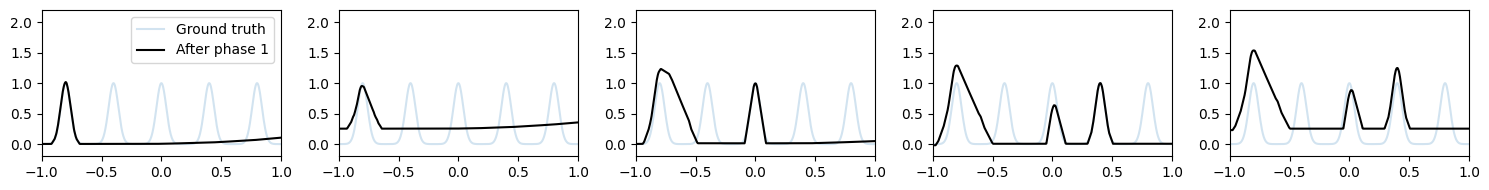

In [11]:
plt.figure(figsize=(15, 2))
for i in range(n_peak):
    plt.subplot(1, n_peak, i + 1)
    plt.plot(x_grid.numpy(), y_grid.numpy(), alpha=0.2, label="Ground truth")
    plt.plot(x_grid.numpy(), ys[i], color='black', label=f"After phase {i+1}")
    plt.ylim(-0.2, 2.2)
    plt.xlim(-1, 1)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()